In [7]:
import collections
import json
import sys

from tvgutil import tvg

from predictutil import get_contact

from aiodtnsim.reports.message_stats_report import print_stat


def load(args):
    print("Loading scenario...", file=sys.stderr)
    scenario = json.load(args.SCENARIO)
    args.SCENARIO.close()
    node_list = (
        [sat["id"] for sat in scenario["satlist"]] +
        [gs["id"] for gs in scenario["gslist"]]
    )
    start_time = scenario["time_offset"]

    print("Loading TVG...", file=sys.stderr)
    ftvg = tvg.from_serializable(json.load(args.FTVG))
    args.FTVG.close()

    print("Loading report file...", file=sys.stderr)
    contacts = []
    pending_contacts = {}
    pending_reverse = set()
    for i, line in enumerate(args.CONN_ONE_REPORT):
        if line[0] == "#" or line.strip() == "":
            continue
        ts, _, node1, node2, updown = line.strip().split(" ")
        key = (node1, node2)
        if updown == "up":
            if key in pending_contacts:
                assert key not in pending_reverse, f"line {i} error: {key} pending already"
                pending_reverse.add(key)
            pending_contacts[key] = float(ts)
        else:
            if key in pending_reverse:
                pending_reverse.remove(key)
                continue
            assert updown == "down", f"wrong value: {updown}"
            mapped_node1 = node_list[int(node1)]
            mapped_node2 = node_list[int(node2)]
            contacts.append((
                mapped_node1,
                mapped_node2,
                start_time + pending_contacts[key],
                start_time + float(ts),
            ))
            del pending_contacts[key]
    args.CONN_ONE_REPORT.close()
    
    return node_list, start_time, ftvg, contacts

Args = collections.namedtuple("Args", ["SCENARIO", "FTVG", "CONN_ONE_REPORT"])

node_list, start_time, ftvg, one_contacts = load(Args(
    open("stint_pubs_rr_scenario_8x90.json", "r"),
    open("ftvg.json", "r"),
    open("../../../the-one/reports/scenario2_EpidemicRouter_ConnectivityONEReport.txt", "r"),
))

print("OK")

OK


Loading scenario...
Loading TVG...
Loading report file...


0 ('gs2', 'BEESAT')
1 ('FIREFLY', 'gs2')
2 ('gs8', 'FLOCK 2K-03')
3 ('DIAMOND RED', 'gs1')
4 ('gs4', 'LINK')
5 ('gs3', 'CUTE-1 (CO-55)')
6 ('gs2', 'FLOCK 2K-03')
7 ('gs8', 'AOXIANG-1')
8 ('gs7', 'FLOCK 2K-03')
9 ('gs6', 'AOXIANG-1')
10 ('CUTE-1 (CO-55)', 'gs9')
11 ('LINK', 'gs0')
12 ('SOMP', 'gs0')
13 ('gs1', 'CUTE-1 (CO-55)')
14 ('BEESAT', 'gs1')
15 ('DIAMOND RED', 'gs7')
16 ('CUTE-1 (CO-55)', 'gs7')
17 ('gs7', 'CUTE-1 (CO-55)')
18 ('gs9', 'AOXIANG-1')
19 ('gs0', 'FLOCK 2K-03')
20 ('CUTE-1 (CO-55)', 'gs8')
21 ('CUTE-1 (CO-55)', 'gs0')
22 ('DIAMOND RED', 'gs0')
23 ('BEESAT', 'gs9')
24 ('AOXIANG-1', 'gs0')
25 ('gs1', 'FIREFLY')
26 ('AOXIANG-1', 'gs3')
27 ('AOXIANG-1', 'gs2')
28 ('gs4', 'DIAMOND RED')
29 ('gs8', 'FIREFLY')
30 ('gs7', 'FIREFLY')
31 ('SOMP', 'gs3')
32 ('gs8', 'GRIFEX')
33 ('gs0', 'AOXIANG-1')
34 ('LINK', 'gs8')
35 ('gs2', 'AOXIANG-1')
36 ('LINK', 'gs6')
37 ('gs6', 'CUTE-1 (CO-55)')
38 ('AOXIANG-1', 'gs9')
39 ('gs1', 'DIAMOND RED')


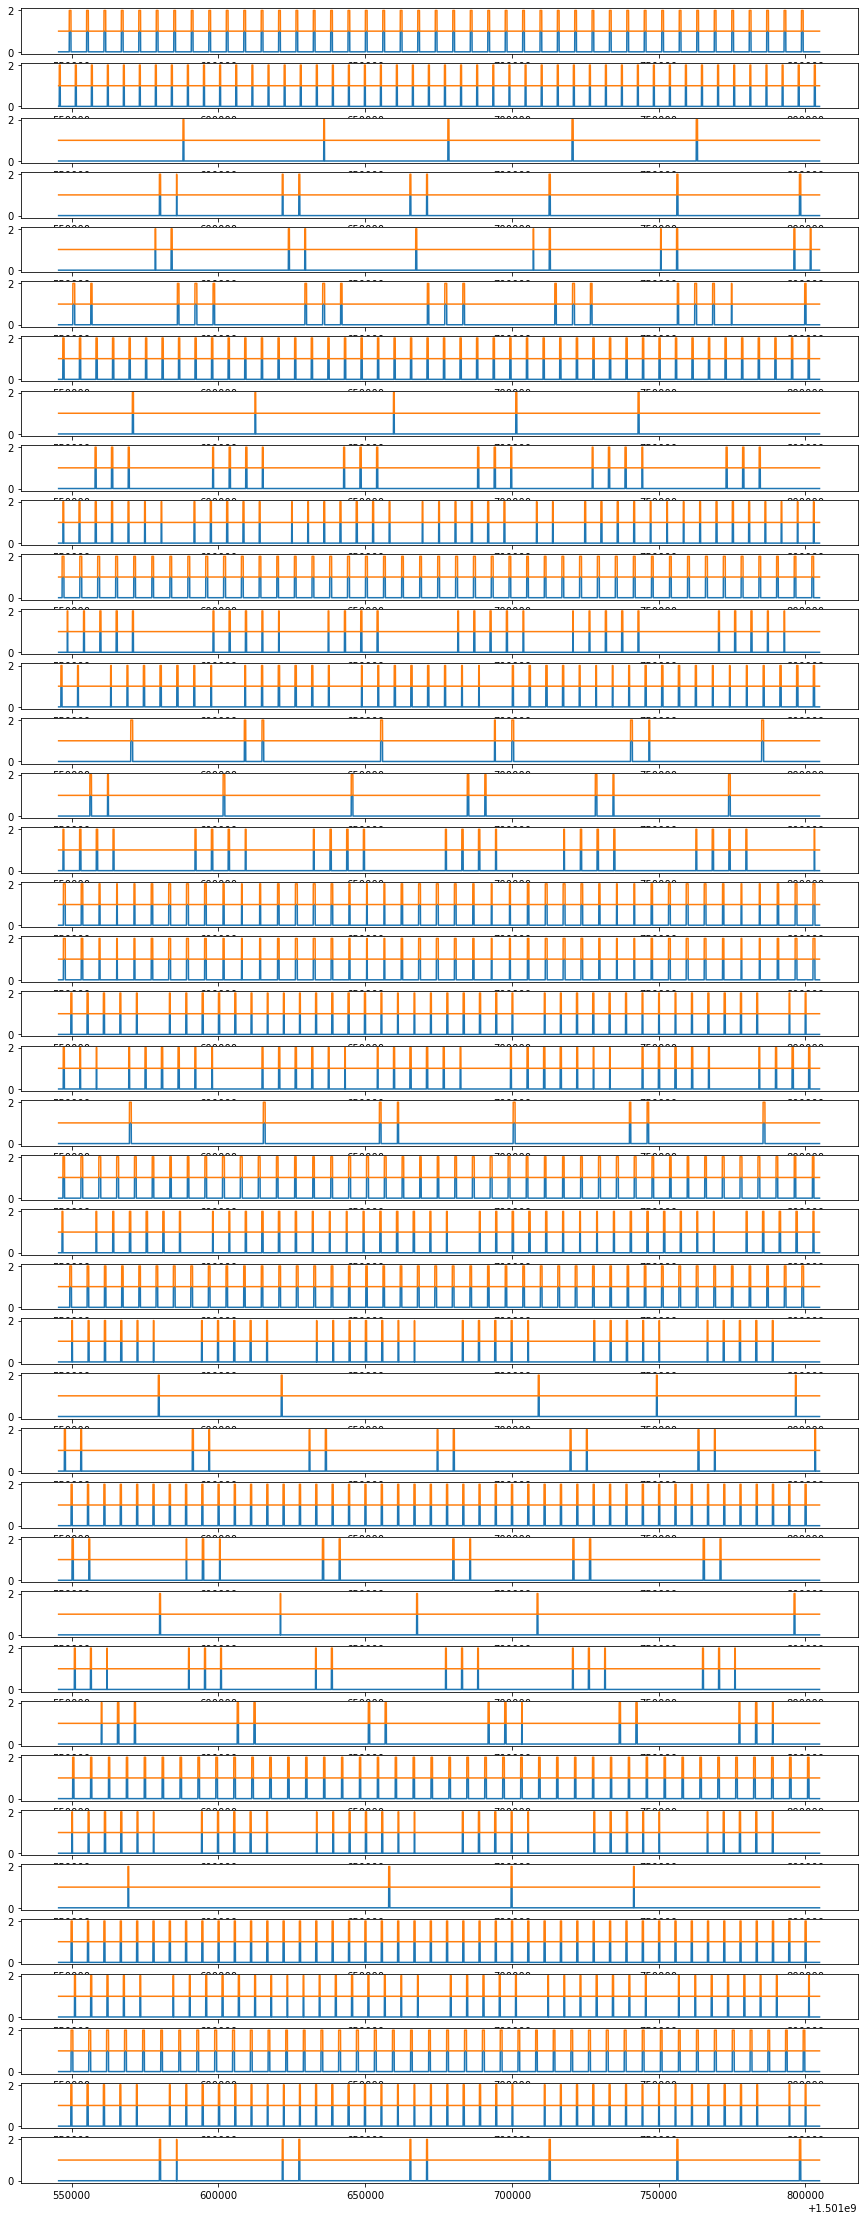

In [8]:
import matplotlib.pyplot as plt
import random

edges = list(ftvg.edges.keys())

start = int(start_time)
end = start + 3 * 86400

COUNT = 40

fig, axes = plt.subplots(COUNT, 1)
    
for i, edge in enumerate(random.sample(edges, COUNT)):
    print(i, edge)
    
    fc_edge = ftvg.edges[edge]

    ftvg_intv = []
    last_t = start
    for fc in fc_edge:
        for t in range(last_t, int(fc.start_time)):
            ftvg_intv.append(0)
        for t in range(int(fc.start_time), int(fc.end_time)):
            ftvg_intv.append(1)
        last_t = int(fc.end_time)
    for t in range(last_t, end):
        ftvg_intv.append(0)

    assert len(ftvg_intv) == end - start, f"{len(ftvg_intv)} != {end - start}"

    one_c_intv = []
    last_t = start
    for node1, node2, ts, te in one_contacts:
        if (node1 == edge[0] and node2 == edge[1]) or (node1 == edge[1] and node2 == edge[0]):
            for t in range(last_t, int(ts)):
                one_c_intv.append(1)
            for t in range(int(ts), int(te)):
                one_c_intv.append(2)
            last_t = int(te)
    for t in range(last_t, end):
        one_c_intv.append(1)

    import matplotlib.pyplot as plt

    ax = axes[i]
    ax.plot(
        [t for t in range(start, end)],
        ftvg_intv,
        label="ftvg_intv",
    )
    ax.plot(
        [t for t in range(start, end)],
        one_c_intv,
        label="ftvg_intv",
    )
    
fig.set_size_inches(15, COUNT)
plt.show()